In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_probability as tfp 
import scipy as sp
import seaborn as sns 

import collections
import sys 

sys.path.append('/Users/alinmorariu/Documents/Github/ContinuousTimeIndividualLevelEpidemicModels')

In [2]:
sns.set_theme()

In [3]:
DTYPE = tf.float64

In [4]:
population_size = 4 # 3 infected, 1 occult 

# Characteristic data simulation

In [5]:
ind_id = ['A', 'B', 'C', 'D']

In [6]:
np.random.seed(20230720)
location_data = np.random.uniform(low = 0.0, high = 10.0, size = (population_size,2))

<AxesSubplot:xlabel='Long', ylabel='Lat'>

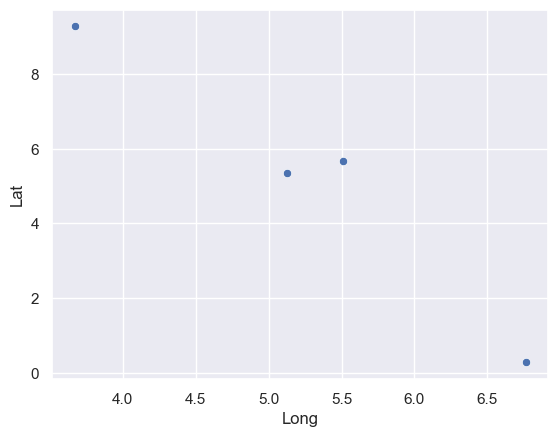

In [7]:
sns.scatterplot(data=pd.DataFrame(
    location_data, columns=('Long', 'Lat')), x='Long', y='Lat')

In [8]:
farm_size = [30, 7, 70, 20]

In [9]:
raw_data = {'ind_id': ind_id,
 'long': location_data[:, 0],
 'lat': location_data[:, 1],
 'farm_size': farm_size}

In [10]:
np.column_stack((location_data[:, 0], location_data[:, 1], farm_size))

array([[ 6.7622786 ,  0.27765238, 30.        ],
       [ 3.67218619,  9.27634228,  7.        ],
       [ 5.51130133,  5.66629101, 70.        ],
       [ 5.12430292,  5.36310558, 20.        ]])

In [11]:
characteristic_data = tf.convert_to_tensor(np.column_stack(
    (location_data[:, 0], location_data[:, 1], farm_size)), dtype=DTYPE, name='long-lat-size')

2023-08-03 15:54:42.104269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
characteristic_data 

<tf.Tensor: shape=(4, 3), dtype=float64, numpy=
array([[ 6.7622786 ,  0.27765238, 30.        ],
       [ 3.67218619,  9.27634228,  7.        ],
       [ 5.51130133,  5.66629101, 70.        ],
       [ 5.12430292,  5.36310558, 20.        ]])>

# Stochastic process

In [13]:
# Define variables to govern epidemic
sir_graph = np.array([[-1, 0],
                      [1, -1],
                      [0, 1]], dtype=np.float32)


initial_state = np.array([[2],
                          [1],
                          [1]], dtype=np.float32)

In [14]:
THEORETICAL_VALUES = tf.constant((0.8, 1.2, 12.14, 2), dtype=DTYPE)
THEORETICAL_VALUES_DICT = {
    'reg': THEORETICAL_VALUES[0:2], 'spatial': THEORETICAL_VALUES[2], 'removal': THEORETICAL_VALUES[3]}

In [15]:
THEORETICAL_VALUES_DICT

{'reg': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.8, 1.2])>,
 'spatial': <tf.Tensor: shape=(), dtype=float64, numpy=12.14>,
 'removal': <tf.Tensor: shape=(), dtype=float64, numpy=2.0>}

In [16]:
ParameterTuple = collections.namedtuple('ParameterTuple', 'regression spatial removal')

In [17]:
INITIAL_VALUES = ParameterTuple(regression=tf.constant([1., 1.], dtype=DTYPE),
                                 spatial=tf.constant(12.14, dtype=DTYPE),
                                 removal=tf.constant(2., dtype=DTYPE))

In [18]:
INITIAL_VALUES._asdict()

{'regression': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>,
 'spatial': <tf.Tensor: shape=(), dtype=float64, numpy=12.14>,
 'removal': <tf.Tensor: shape=(), dtype=float64, numpy=2.0>}

In [19]:
###########
# Hazard fn
###########

# 1. Compute spatial component
def pairwise_distance(location_data):
    """Compute pairwise distance matrix between farms

    Args:
        farm_locations_data (DataFrame): Lat-Long coordinates of farms

    Returns:
        tensor: tensor of Euclidean distances between entities
                Dim = len(farm_location_data)
    """
    return tf.convert_to_tensor(
        sp.spatial.distance.squareform(
            sp.spatial.distance.pdist(location_data)
        ),
        dtype=DTYPE
    )


def generate_spatial_kernel(location_data):
    # compute distances between farms (i.e. [rho(i,j)] )
    farm_distance_matrix = pairwise_distance(location_data)
    farm_distance_matrix = tf.convert_to_tensor(
        farm_distance_matrix, DTYPE)

    def square_exponential_kernel(parameters):
        parameters = tf.convert_to_tensor(parameters, DTYPE)
        partial_step = tf.math.multiply(farm_distance_matrix, 1/parameters)
        return tf.math.exp(-tf.math.square(partial_step))

    return square_exponential_kernel

# 2. Compute regression component


def generate_regression_pressure(characteristic_data=None):
    """_summary_

    Args:
        farm_characteristics_data (_type_, optional): Factor variables for each farm unit. Defaults to None.

    Returns:
        tensor: exp(alpha + beta * data)
    """
    characteristic_data = tf.convert_to_tensor(characteristic_data, DTYPE)

    def compute_regression(parameters):
        parameters = tf.convert_to_tensor(parameters, DTYPE)
        # note: char_data is a column vector so this needs to change for general case
        one_padded_data = tf.stack([np.full(np.shape(characteristic_data), 1.0),
                                    characteristic_data], axis=-1)
        regression = tf.matmul(one_padded_data, tf.expand_dims(parameters,-1))
        expontiated_regression = tf.math.exp(-regression)
        return expontiated_regression

    return compute_regression

# 3. Combine for overall hazard function


def generate_pairwise_hazard_fn(location_data, characteristic_data):
    """_summary_

    Args:
        farm_characteristics_data (_type_): features of farms, including a 1s column for regression
        farm_locations_data (_type_): Northing-Easting coordinates of farms

    Returns:
        fn: fn which outputs a tensor of pairwise hazard rates
    """
    spatial_kernel = generate_spatial_kernel(location_data)
    regression_kernel = generate_regression_pressure(characteristic_data)

    def compute_hazard(parameters_tuple):

        # spatial component - already exponentiated!
        spatial = spatial_kernel(parameters_tuple.spatial)

        # regression component - already exponentiated!
        regression = regression_kernel(parameters_tuple.regression)
        return tf.math.multiply(spatial,
                                regression
                                )

    return compute_hazard

In [20]:
generate_spatial_kernel(location_data)(INITIAL_VALUES.spatial)

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[1.        , 0.54105691, 0.81249689, 0.82391974],
       [0.54105691, 1.        , 0.89460071, 0.88850751],
       [0.81249689, 0.89460071, 1.        , 0.99836143],
       [0.82391974, 0.88850751, 0.99836143, 1.        ]])>

In [21]:
characteristic_data[:, -1]

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([30.,  7., 70., 20.])>

In [22]:
# example usage 
generate_pairwise_hazard_fn(
    location_data=location_data,
    characteristic_data=tf.stack(characteristic_data[:, -1]))(INITIAL_VALUES) 

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[3.44247711e-14, 1.86257603e-14, 2.79700195e-14, 2.83632485e-14],
       [1.81504373e-04, 3.35462628e-04, 3.00105105e-04, 2.98061063e-04],
       [1.18826551e-31, 1.30834122e-31, 1.46248623e-31, 1.46008985e-31],
       [6.24742122e-10, 6.73716185e-10, 7.57013591e-10, 7.58256043e-10]])>

In [23]:
############
# Removal fn
############

def generate_removal_fn(infection_time, removal_time):
    time_diff = removal_time - infection_time

    def removal_fn(parameters):
        return tfp.distributions.Exponential(rate=parameters).log_prob(time_diff)
    return removal_fn

The hazard functions and removal function correspond to the $S \rightarrow I$ and $I \rightarrow R$ transitions of the $SIR$ model. They can be combined in order to evaluate the likelihood of the epidemic. Implementation requires the raw data (called the characteristic data in the code above) and timestamps for the epidemic events. We create a closure over the model parameters (target of the MCMC scheme) and evaluate the likelihood at proposed parameter values. Several additional functions are required in order to compute the like likelihood. The hazard function quantifies pairwise infectious pressure but does not factor in the directionality of that pressure since it is missing information about the ordering of events (i.e. at a given time, a susceptible individual does not exert infectious pressure on another susceptible individual, but an infectious individual does exert infectious pressure on susceptibles). Direction of infection is determined by the computation of a "who acquired infection from who" (called the WAIFW matrix). The WAIFW matrix encodes if individual $j$ is exerts infectious pressure on individual $i$ by checking for overlap of individual $j$'s infectious period with individual $i$'s susceptible period. 

In [24]:
def generate_waifw(infection_times, removal_times):
    """
    Compute a WAIFW (who acquired infection from who) matrix 
    given tensors of infection and removal times. 

    Args:
        infection_times (datetime): array of infection times 
        removal_times (datetime): array of removal times 

    Returns:
        tensor: len(infection_times) x len(infection_times) tensor of 1s and 0s
    """

    infection_times = tf.convert_to_tensor(infection_times, dtype=DTYPE)
    removal_times = tf.convert_to_tensor(removal_times, dtype=DTYPE)

    # use the expand_dim to do the [I,:] trick
    waifw = tf.math.logical_and(
        # compare infections to infections: I_i <= I_j
        infection_times[tf.newaxis, :] < infection_times[:, tf.newaxis],
        # compare infections to removals: I_j <= R_i
        infection_times[:, tf.newaxis] < removal_times[tf.newaxis, :]
    )
    return tf.cast(waifw,
                   dtype=DTYPE)

With the direction of infectious pressure being determined, we now turn to the exposure matrix which provides the duration that infectious pressure is exerted from one individual to another. 

In [25]:
def generate_exposure(infection_times, removal_times):
    """
    Compute exposure matrix given two tensors of infections and removal times

    Args:
        infection_times (datetime): array of infection times 
        removal_times (datetime): array of removal times 

    Returns:
        tensor: len(infection_times) x len(infection_times) tensor of exposure
        durations 
    """
    infection_times = tf.convert_to_tensor(infection_times, dtype=DTYPE)
    removal_times = tf.convert_to_tensor(removal_times, dtype=DTYPE)

    return (
        tf.math.minimum(infection_times[:, tf.newaxis],
                        removal_times[tf.newaxis, :]) -
        tf.math.minimum(infection_times[:, tf.newaxis],
                        infection_times[tf.newaxis, :])
    )

In [26]:
def identify_initial_infective(infection_times):
    infection_times = tf.convert_to_tensor(infection_times, dtype=DTYPE)
    return tf.argmin(infection_times, name='initial_infective_individual')

## Create fake dates

In [27]:
# Create fake dates 
epidemic_timestamps = {'ind_id': ind_id,
 'infection_time': np.array([0, 5.4, 3.7835, 12.0]),
'removal_time': np.array([6.111, 8.4954, 10.03313, 12.0])}

### Data cleaning convention

In a dataset of infective and occult units, set the infection *and* removal time of the occults to $T_{\max}$

In [28]:
def generate_infectious_duration(infection_times, removal_times):
    infection_times = tf.convert_to_tensor(infection_times, dtype=DTYPE)
    removal_times = tf.convert_to_tensor(removal_times, dtype=DTYPE)
    return tf.math.subtract(x=removal_times,
                            y=infection_times)

In [29]:
# example
generate_infectious_duration(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time'))

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([6.111  , 3.0954 , 6.24963, 0.     ])>

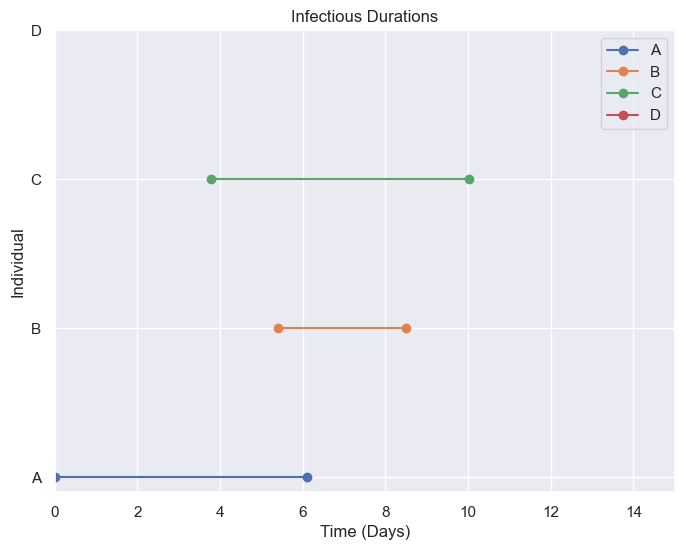

In [30]:
# Dataset
data = {
    'ind_id': ind_id,
    'infection_time': [0.0000, 5.4000, 3.7835, float('inf')],
    'removal_time': [6.11100, 8.49540, 10.03313, float('inf')]
}

# Calculate difference
difference = generate_infectious_duration(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time'))

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the difference as a line connecting infection_time and removal_time
for i, individual in enumerate(data['ind_id']):
    plt.plot([data['infection_time'][i], data['removal_time'][i]], [individual, individual], marker='o', label=individual)

plt.xlabel('Time (Days)')
plt.ylabel('Individual')
plt.xlim(0, 15)
plt.yticks(data['ind_id'])
plt.grid(True)
plt.legend()
plt.title('Infectious Durations')

plt.show()

In [31]:
# Exposure fn
generate_exposure(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time')) 

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[0.     , 0.     , 0.     , 0.     ],
       [5.4    , 0.     , 1.6165 , 0.     ],
       [3.7835 , 0.     , 0.     , 0.     ],
       [6.111  , 3.0954 , 6.24963, 0.     ]])>

In [32]:
# WAIFW
generate_waifw(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time'))

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[0., 0., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.]])>

In [33]:
# Hazard fn
generate_pairwise_hazard_fn(
    location_data=location_data,
    characteristic_data=tf.stack(characteristic_data[:, -1]))(INITIAL_VALUES) 

<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[3.44247711e-14, 1.86257603e-14, 2.79700195e-14, 2.83632485e-14],
       [1.81504373e-04, 3.35462628e-04, 3.00105105e-04, 2.98061063e-04],
       [1.18826551e-31, 1.30834122e-31, 1.46248623e-31, 1.46008985e-31],
       [6.24742122e-10, 6.73716185e-10, 7.57013591e-10, 7.58256043e-10]])>

# Log-likelihood evaluation

In [34]:
# block 1 - event rate
# math: [log (WAIFW cdot (H_{I,I}) cdot 1v )] cdot 1v
def event_rate_block(waifw_matrix, hazard_matrix):
    log_rates = tf.math.log(
        tf.einsum('ij -> i', tf.matmul(a=waifw_matrix, b=hazard_matrix)))
    log_rates = tf.where(tf.math.is_inf(log_rates),
                         tf.constant(0.0, dtype=DTYPE), log_rates)  # remove np.inf (initial inf and occults)
    return tf.reduce_sum(log_rates)

# This function hides the matrix multiplications within the log_ll computation - no need to write as a closure

In [35]:
# Write test for block 1 

In [36]:
# block 2 - infectious pressure p.w. approximation 
# math: ((E cdot H_{I,I} ) cdot 1v cdot 1v
def infectious_pressure_block(hazard_matrix, exposure_matrix):
    infection_pressure = tf.matmul(a=hazard_matrix, b=exposure_matrix)
    return tf.reduce_sum(infection_pressure)

# This function hides the matrix multiplications within the log_ll computation - no need to write as a closure

In [37]:
# Write test for block 2

In [38]:
# block 3 - removal process
# math: log_prob(D)
def removal_process_block(known_event_times):
    # these can be moved one level deeper into the closure if they
    # are unknown (i.e. are model parameters)

    infection_time = known_event_times['infection_time']
    removal_time = known_event_times['removal_time']

    def removal_process_block_eval(removal_rate):
        # TO DO: add parameter to create a removal rate fn?

        # set exponential removal times with rate = removal_rate
        removal_process = tfp.distributions.Exponential(rate=removal_rate)

        # compute D 
        infectious_duration = removal_time - infection_time
        
        # compute log prob - account for P(X = 0) = lambda in exp distribution
        # handles occults since their infectious duration is 0 so they don't 
        # have a removal time - convention is that occults had I = R = T_maxlog
        log_prob_duration = tf.where(infectious_duration > 0,
                                     removal_process.log_prob(
                                         infectious_duration),
                                     0.0)
        
        return tf.reduce_sum(log_prob_duration)
    return removal_process_block_eval

In [39]:
# Write test for block 3
removal_process_block(known_event_times = epidemic_timestamps)(removal_rate = INITIAL_VALUES.removal)

<tf.Tensor: shape=(), dtype=float64, numpy=-28.832618458320162>

In [40]:
def log_ll(hazard_rate_function, known_event_times):

    @tf.function(jit_compile=False)
    def log_ll_eval(parameters_tuple):
        # Compute matrices 
        hazard_mat = hazard_rate_function(parameters_tuple)

        waifw_mat = generate_waifw(infection_times=known_event_times['infection_time'],
                                   removal_times=known_event_times['removal_time'])

        exposure_mat = generate_exposure(infection_times=known_event_times['infection_time'],
                                         removal_times=known_event_times['removal_time'])
        
        # Remove? 
        initial_infective_individual = identify_initial_infective(
            infection_times=epidemic_timestamps['infection_time'])
        # I don't think I need this anymore^
        # Initial infective has their contribution put to zero in block 1 automatically

        # Block 1: [log (WAIFW cdot (H_{I,I}) cdot 1v )] cdot 1v

        block1 = event_rate_block(waifw_matrix=waifw_mat,
                                  hazard_matrix=hazard_mat)

        # Block 2: - ((E cdot H_{I,I} ) cdot 1v cdot 1v

        block2 = infectious_pressure_block(hazard_matrix=hazard_mat,
                                           exposure_matrix=exposure_mat)

            # Block 3: log_prob(D)

        removal_process = removal_process_block(
            known_event_times=known_event_times)

        # evaluate the contribution
        block3 = removal_process(removal_rate=parameters_tuple.removal)

        return block1 + block2 + block3
    return log_ll_eval

In [41]:
# example usage 
hazard_fn = generate_pairwise_hazard_fn(
            location_data=location_data,
            characteristic_data=characteristic_data[:, -1])

log_ll(hazard_fn, known_event_times=epidemic_timestamps)(INITIAL_VALUES) 

<tf.Tensor: shape=(), dtype=float64, numpy=-88.51234958139446>

In [42]:
INITIAL_VALUES._asdict()

{'regression': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>,
 'spatial': <tf.Tensor: shape=(), dtype=float64, numpy=12.14>,
 'removal': <tf.Tensor: shape=(), dtype=float64, numpy=2.0>}

# Inference 

In [43]:
# Priors for all parameters
def prior_distributions_block(initial_values_tuple):
    # Goal: priors to be initialized w/ arguments
    # (initial_values, distribution, distribution_param)
    # inital value are used to set up the shapes of the priors

    # initialize tfp.distributions
    reg_priors = tfp.distributions.Normal(loc=tf.broadcast_to(tf.constant(
        0., dtype=DTYPE), tf.shape(initial_values_tuple.regression)), scale=10.)

    spatial_priors = tfp.distributions.Normal(loc=tf.broadcast_to(tf.constant(
        0., dtype=DTYPE), tf.shape(initial_values_tuple.spatial)), scale=10.)

    removal_priors = tfp.distributions.Normal(loc=tf.broadcast_to(tf.constant(
        0., dtype=DTYPE), tf.shape(initial_values_tuple.removal)), scale=10.)

    def prior_eval(parameters):
        reg_block = tf.reduce_sum(reg_priors.log_prob(initial_values_tuple.regression))
        spatial_block = tf.reduce_sum(
            spatial_priors.log_prob(initial_values_tuple.spatial))
        removal_block = tf.reduce_sum(
            removal_priors.log_prob(initial_values_tuple.removal))

        return reg_block + spatial_block + removal_block
    return prior_eval

In [44]:
# Write test for prior function 
prior_distributions_block(INITIAL_VALUES)(INITIAL_VALUES)

<tf.Tensor: shape=(), dtype=float64, numpy=-13.652992504794874>

In [45]:
# target lob prob
def target_log_prob_fn(log_likelihood_fn, prior_dist_fn):
    """Combine log-likelihood and prior distributions to create the 
    target log prob fn used in inference

    Args:
        log_likelihood_fn (fn): log-likelihood fn of the model
        prior_dist_fn (fn): prior distribution fn of the model parameters

    Returns:
        float64: evaluation of the target log prob

    Notes: 
    The inner fn operates on an unpacked version of the ParameterTuple
    in order to be able to take advantage of partial function 
    evaluations in the functools package. 
    """
    # initialize the two parts
    def target_log_prob_eval(regression_param, spatial_param, removal_param):
        # pack up the parameters (lazy way so we don't need to
        # change the structure of the other functions above)
        parameters_tuple = ParameterTuple(regression_param,
                                          spatial_param,
                                          removal_param)

        return log_likelihood_fn(parameters_tuple) + prior_dist_fn(parameters_tuple)
    return target_log_prob_eval

In [46]:
# Write test for target log prob fn

TLP = target_log_prob_fn(log_likelihood_fn=log_ll(hazard_fn, known_event_times=epidemic_timestamps),
                  prior_dist_fn=prior_distributions_block(INITIAL_VALUES))

TLP

<function __main__.target_log_prob_fn.<locals>.target_log_prob_eval(regression_param, spatial_param, removal_param)>

In [48]:
TLP(*INITIAL_VALUES)

<tf.Tensor: shape=(), dtype=float64, numpy=-102.16534208618933>

In [49]:
# RWMH transition kernel
RWMHResult = collections.namedtuple('RWMHResult', ['is_accepted',
                                                   'current_state',
                                                   'current_state_log_prob'
                                                   ]
                                    )

In [50]:
proposal_sigma_values = ParameterTuple(regression=tf.constant([0.01, 0.01], dtype = DTYPE),
                                       spatial=tf.constant(0.2, dtype = DTYPE),
                                       removal=tf.constant(0.01, dtype = DTYPE))

In [51]:
opitmal_proposals = ParameterTuple(regression=tf.constant([2*0.0626987, 2*0.048898], dtype = DTYPE),
                                   spatial=tf.constant(2*4.0604401, dtype = DTYPE),
                                   removal=tf.constant(2*0.0322145, dtype = DTYPE))

In [52]:
INITIAL_VALUES

ParameterTuple(regression=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>, spatial=<tf.Tensor: shape=(), dtype=float64, numpy=12.14>, removal=<tf.Tensor: shape=(), dtype=float64, numpy=2.0>)

In [81]:
# Proposal distributions

def generate_gaussian_proposal(scale):
    """Instantiate a Gaussian proposal for an MCMC kernel 

    Args:
        scale (float64): the scale of the proposal distribution. 
        Must contain only positive values. 

    Returns:
        fn: proposal function with a fixed scale parameter. The
        function takes in the current chain state and a seed, 
        and returns a sample of size 1 matching the current 
        state dimensions
    """
#     # set scale to correct dtype
#     scale = tf.constant(scale, dtype=DTYPE)

    def gaussian_proposal(current_state, seed):
        """Propose next state in an MCMC chain given a current
        state and a seed 

        Args:
            current_state (float64): vector of values of the 
            current chain state
            seed (int): PRNG seed

        Returns:
            float64: suggested next state for the chain
        """
        loc = current_state
        isotropic_normal = tfp.distributions.Normal(
            loc=loc, scale=scale)
        return isotropic_normal.sample(seed=seed)
    return gaussian_proposal

In [82]:
@tf.function(jit_compile=True)
def RandomWalkMetropolisHastings_baseline(
        target_log_prob_fn, initial_state_tuple, proposal_sigma_tuple,
        num_iter=15, seed=None):

    seed = tfp.random.sanitize_seed(
        seed, salt="RandomWalkMetropolisHastings_baseline")

    # Instantiate proposal distributions - a ParameterTuple containing
    # fn's corresponding to the proposal of each block of inference
    Qx_tuple = tf.nest.map_structure(
        lambda x: generate_gaussian_proposal(x), proposal_sigma_tuple)

    # Instantiate the TLP - place holder in case we want to make this
    # depend on other data and want to combine it within the function
    TFP = target_log_prob_fn

    def bootstrap_result(initial_state_tuple):
        kernel_results = RWMHResult(
            is_accepted=tf.ones_like(TFP(
                *initial_state_tuple), dtype=tf.bool),
            current_state=initial_state_tuple,
            current_state_log_prob=TFP(*initial_state_tuple)
        )
        return ParameterTuple(kernel_results, kernel_results, kernel_results)

    def one_step(current_state, previous_kernel_result, seed):
        # pick up most recent update log prob
        seeds = tfp.random.split_seed(seed, n=len(
            current_state._fields), salt="one_step")

        current_state_log_prob = previous_kernel_result[-1].current_state_log_prob

        # iterate over each of the blocks we want to update
        intermediate_kernel_results = []

        # TO DO -- Eliminate the for loop over the current state by creating
        # a namedtuple over which maps each field to it's own one_step fn. Each one_step
        # fn instantiates its own proposal fn. Parameters come from a namedtuple over
        # the same fields - i.e. create a fn to *make* a proposal (closure over the
        # variance with the current state providing the mean). End goal is to iterate
        # over a namedtuple fields with signatures ([current_partial_state], [partial_target_log_prob],
        # [proposal_fn]).

        # NEXT TO DO -- unpack the namedtuple of parameters to be arguments
        # for the target_log_prob and take advantage of the partial evaluation fn. We
        # want to make a wrapper one_step fn that acts as a pipe for all the kernels
        # that need to be evaluated in one step of the MCMC

        # IDEA -- kernels can be stacked using tf.scan?

        for field, seed in zip(current_state._fields, seeds):

            # seed handling
            proposal_seed, accept_seed = tfp.random.split_seed(
                seed, n=2, salt="for_loop")

            # pick up partial state (maps to block to perform inference on)
            partial_current_state = getattr(current_state, field)

            #########
            # Propose next step
            proposal_fn = getattr(Qx_tuple, field)
            next_partial_state = proposal_fn(
                partial_current_state, proposal_seed)

            # overright type - Bad for memory I know
            next_complete_state = current_state._replace(
                **{field: next_partial_state})

            #########
            # Compute log accept ratio
            next_target_log_prob = TFP(
                *next_complete_state)

            log_accept_ratio = next_target_log_prob - \
                current_state_log_prob

            # Accept reject step
            log_uniform = tf.math.log(tfp.distributions.Uniform(
                high=tf.constant(1., dtype=DTYPE)).sample(seed=accept_seed))

            is_accepted = log_uniform < log_accept_ratio

            current_state = tf.cond(
                is_accepted, lambda: next_complete_state, lambda: current_state)
            current_state_log_prob = tf.cond(
                is_accepted, lambda: next_target_log_prob,
                lambda: current_state_log_prob)

            new_kernel_results = RWMHResult(
                is_accepted=is_accepted,
                current_state=current_state,
                current_state_log_prob=current_state_log_prob
            )
            intermediate_kernel_results.append(new_kernel_results)
        # this only keeps track of accept/reject of last block
        # new_kernel_results

        return current_state, ParameterTuple(*intermediate_kernel_results)

    # Perform sampling - use the tf.while_loop fn and style
    # Require: body fn and cond fn (i.e. perform body while cond is true)
    # Write the results to the following accumulators

    # Chain values - a ParameterTuple of TensorArrays which expand at each
    # iteration with the next value from the one_step fn
    parameter_samples = tf.nest.map_structure(
        lambda x: tf.TensorArray(dtype=x.dtype, size=num_iter),
        initial_state_tuple)
    # One step result tracker - a ParameterTuple of RMWHResult tuples tracking each
    # sub-kernel outcome (instances of the intermediate_kernel_results)
    mcmc_results = tf.nest.map_structure(
        lambda x: tf.TensorArray(dtype=x.dtype, size=num_iter),
        bootstrap_result(initial_state_tuple))

    def cond(ii,
             current_state,
             previous_kernel_result,
             parameter_samples,
             mcmc_results,
             seed):
        return ii < num_iter

    def body(ii,
             current_state,
             previous_kernel_result,
             parameter_samples,
             mcmc_results,
             seed):
        # Perform one step of in the chain
        this_seed, next_seed = tfp.random.split_seed(seed, n=2, salt="body")
        next_state, next_kernel_result = one_step(
            current_state=current_state,
            previous_kernel_result=previous_kernel_result, seed=this_seed)

        # Track the outcome - CHAIN STATE
        parameter_samples = tf.nest.map_structure(lambda x, a: a.write(ii, x),
                                                  next_state, parameter_samples)
        # # Track the outcome - KERNEL STATE(S)
        mcmc_results = tf.nest.map_structure(lambda x, a: a.write(ii, x),
                                             next_kernel_result, mcmc_results)

        return (ii + 1,
                next_state,
                next_kernel_result,
                parameter_samples,
                mcmc_results,
                next_seed)

    (_1,
     _2,
     _3,
     parameter_samples,
     mcmc_results,
     _4) = tf.while_loop(cond=cond,
                         body=body,
                         loop_vars=(0,
                                    initial_state_tuple,
                                    bootstrap_result(
                                        initial_state_tuple),
                                    parameter_samples,
                                    mcmc_results,
                                    seed))

    # Formatting
    def stack(arr):
        return arr.stack()
    parameter_samples = tf.nest.map_structure(
        lambda x: x.stack(), parameter_samples)

    mcmc_results = tf.nest.map_structure(lambda x: x.stack(),  mcmc_results)

    return parameter_samples, mcmc_results

In [72]:
# Tuning parameters for the proposals
opitmal_proposals = ParameterTuple(regression=tf.constant([0.0082, 1.0826], dtype=DTYPE),
                                   spatial=tf.constant(0.5, dtype=DTYPE),
                                   removal=tf.constant(0.5, dtype=DTYPE))

In [77]:
tf.nest.map_structure(
        lambda x: generate_gaussian_proposal(x), opitmal_proposals)._asdict()

{'regression': <function __main__.generate_gaussian_proposal.<locals>.gaussian_proposal(current_state, seed)>,
 'spatial': <function __main__.generate_gaussian_proposal.<locals>.gaussian_proposal(current_state, seed)>,
 'removal': <function __main__.generate_gaussian_proposal.<locals>.gaussian_proposal(current_state, seed)>}

In [83]:
N = 10_0

chains, results = RandomWalkMetropolisHastings_baseline(
    target_log_prob_fn=TLP, 
    initial_state_tuple=INITIAL_VALUES, 
    proposal_sigma_tuple=opitmal_proposals,
    num_iter= N)

In [84]:
# Adaptive MCMC calcs 
tf.nest.map_structure(lambda x: (1/tf.shape(x)[-1])*2.38 * np.cov(x, rowvar = False), chains)._asdict()

{'regression': <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[7.19994772e-05, 2.11518284e-02],
        [2.11518284e-02, 7.17681831e+00]])>,
 'spatial': <tf.Tensor: shape=(), dtype=float64, numpy=1.154362822266222>,
 'removal': <tf.Tensor: shape=(), dtype=float64, numpy=0.10369760288597547>}

Text(0.5, 0, 'Iterations')

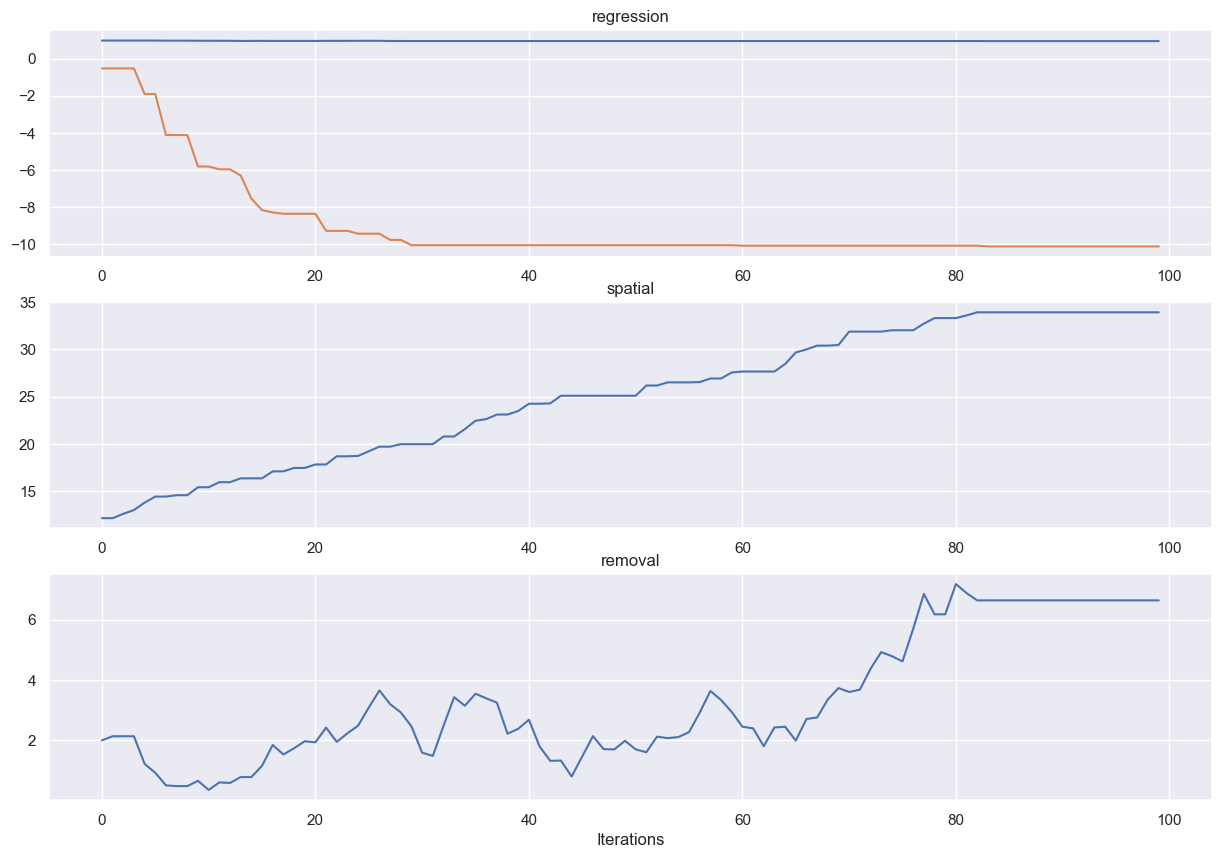

In [85]:
param_names = chains._fields
fig, ax = plt.subplots(len( chains._fields), figsize=(15, 10))
for i, ax in enumerate(ax.flatten()):
    ax.plot(chains[i], )
    ax.set_title(param_names[i])
    
ax.set_xlabel('Iterations')

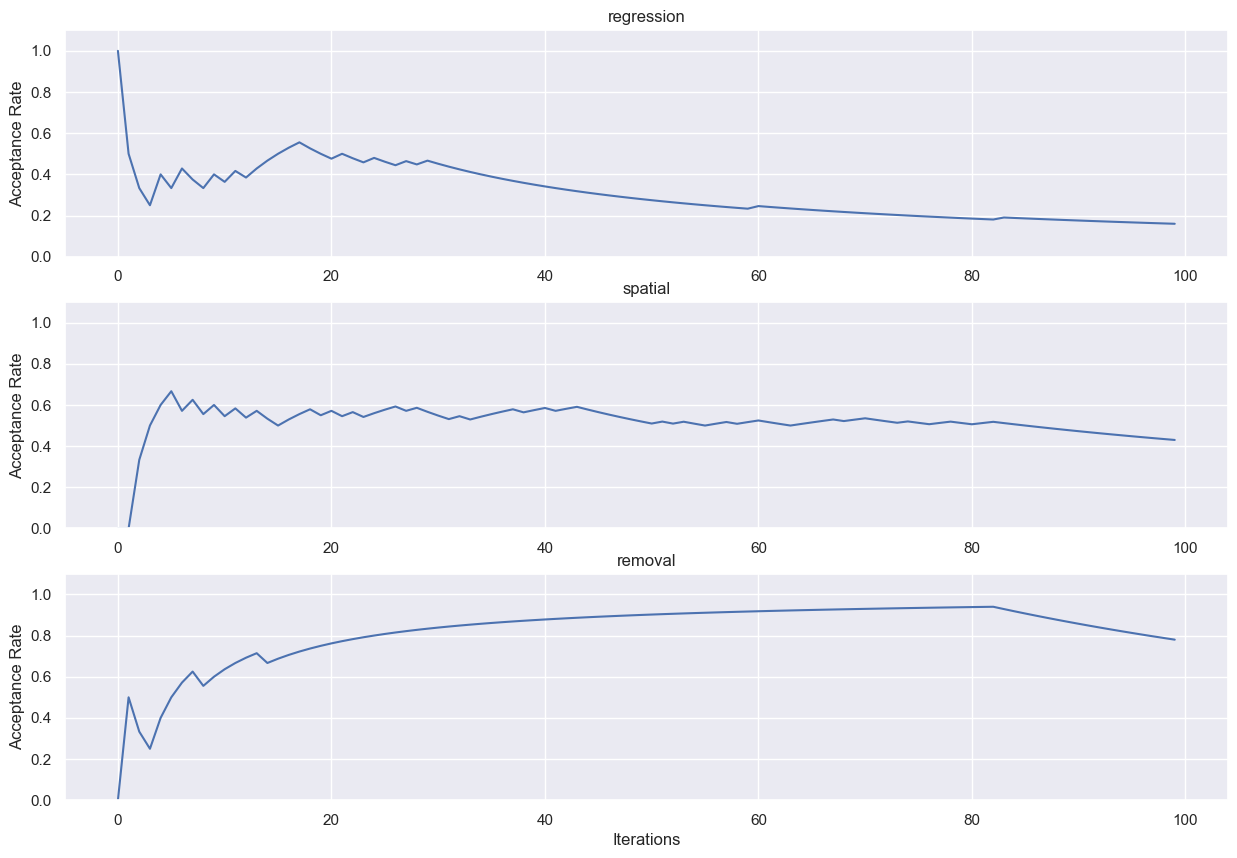

In [86]:
fig, ax = plt.subplots(len(chains._fields), figsize=(15, 10))
for i, ax in enumerate(ax.flatten()):
    ax.plot(np.cumsum(results[i].is_accepted)/range(1, N+1), )
    ax.set_title(param_names[i])
    ax.set_ylabel('Acceptance Rate')
    ax.set_ylim(bottom=0, top=1.1)

    plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

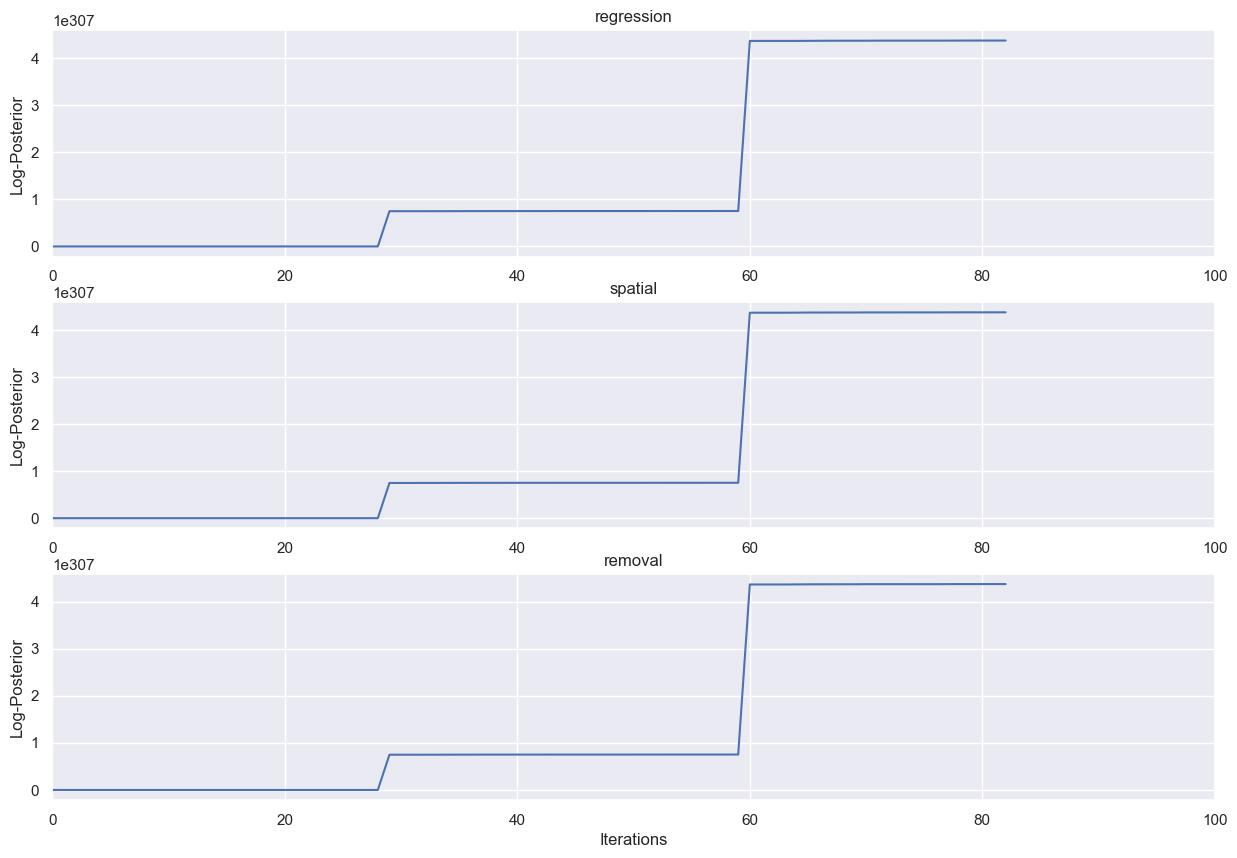

In [87]:
param_names = chains._fields
fig, ax = plt.subplots(len( chains._fields), figsize=(15, 10))
for i, ax in enumerate(ax.flatten()):
    ax.plot(results[i].current_state_log_prob, )
    ax.set_title(param_names[i])
    ax.set_ylabel('Log-Posterior')   
    ax.set_xlim(left= 0, right = N)
    
ax.set_xlabel('Iterations')

In [88]:
INITIAL_VALUES

ParameterTuple(regression=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>, spatial=<tf.Tensor: shape=(), dtype=float64, numpy=12.14>, removal=<tf.Tensor: shape=(), dtype=float64, numpy=2.0>)